In [1]:
!pip install -U git+https://github.com/albumentations-team/albumentations

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1qqq5qfp
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1qqq5qfp
  Resolved https://github.com/albumentations-team/albumentations to commit 662190df63da5ed14ca14883ed20478c5fec8e83
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 16.1 MB/s eta 0:00:00
  Created wheel for albumentations: filename=albumentations-1.4.21-py3-none-any.whl size=267925 sha256=a1dd6c7b84bb4

In [3]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2,os,random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode,plot,iplot

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array, load_img
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only=False)
directory = "../input/chest-xray-pneumonia/chest_xray"

print(colored("required libraries successfully imported..",color="green",attrs=['bold','dark']))

required libraries successfully imported..


In [5]:
print(tensorflow.config.list_physical_devices('GPU'))
print('______________________')
print(tensorflow.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability = None))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]
______________________
False


In [6]:
print("Current tensorflow version=={}".format(tensorflow.__version__))

Current tensorflow version==2.15.0


In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:09<00:00, 248MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [8]:
import pandas as pd
print(path)
# data = pd.read_csv(f"{path}/chest_xray_metadata.csv")
# print(data.head())
!ls -l /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2

/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
total 4
drwxr-xr-x 7 root root 4096 Nov 20 12:51 chest_xray


In [9]:
!cp -r /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2 /content/chest-xray-pneumonia

In [10]:
train_df = glob.glob("/content/chest-xray-pneumonia/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/chest-xray-pneumonia/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/chest-xray-pneumonia/chest_xray/val/**/*.jpeg")
print(colored("The datasets were successfully loaded..",color='green',attrs=['bold','dark']))

The datasets were successfully loaded..


In [11]:
train_df[:5],test_df[:5]

(['/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person61_bacteria_288.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person58_bacteria_272.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person567_bacteria_2354.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person470_bacteria_1999.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person623_virus_1197.jpeg'],
 ['/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person88_bacteria_438.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person114_bacteria_544.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person113_bacteria_542.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person1662_virus_2875.jpeg',
  '/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person99_bacteria_474.jpeg'])

In [12]:
print("There are {} images in the training dataset".format(len(train_df)))
print("There are {} images in the test dataset".format(len(test_df)))
print("There are {} images in the validation dataset".format(len(validation_df)))


There are 5216 images in the training dataset
There are 624 images in the test dataset
There are 16 images in the validation dataset


## EDA

In [13]:
datasets, pneumonia_lung,normal_lung = ["train","test","val"],[],[]
for i in datasets:
  path2 = os.path.join('/content/chest-xray-pneumonia/chest_xray/',i)
  normal = glob.glob(os.path.join(path2,"NORMAL/*.jpeg"))
  pneumonia = glob.glob(os.path.join(path2,"PNEUMONIA/*.jpeg"))
  normal_lung.extend(normal),pneumonia_lung.extend(pneumonia)
print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 4273
The number of non-pneumonia images is 1583


Shuffling the images

In [14]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50]+pneumonia_lung[:50]
images[:10]

['/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-1376-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0716-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0910-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0780-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0172-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0807-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0272-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/test/NORMAL/NORMAL2-IM-0351-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0101-0001.jpeg',
 '/content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0601-0001.jpeg']

NORMAL


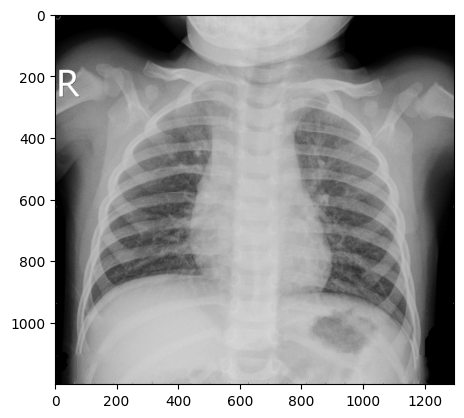

In [15]:
normal_lung_image = load_img(normal_lung[0])
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

pneumonia


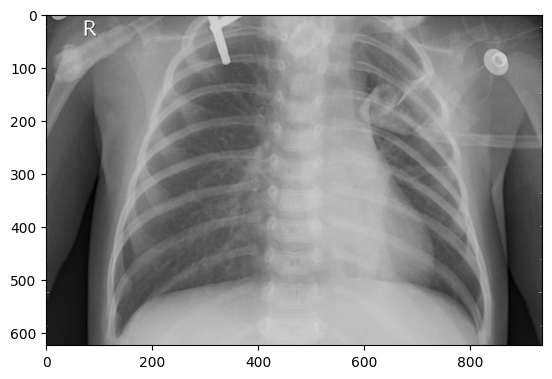

In [16]:
pneumonia_lung_image = load_img(pneumonia_lung[0])
print("pneumonia")
plt.imshow(pneumonia_lung_image)
plt.show()

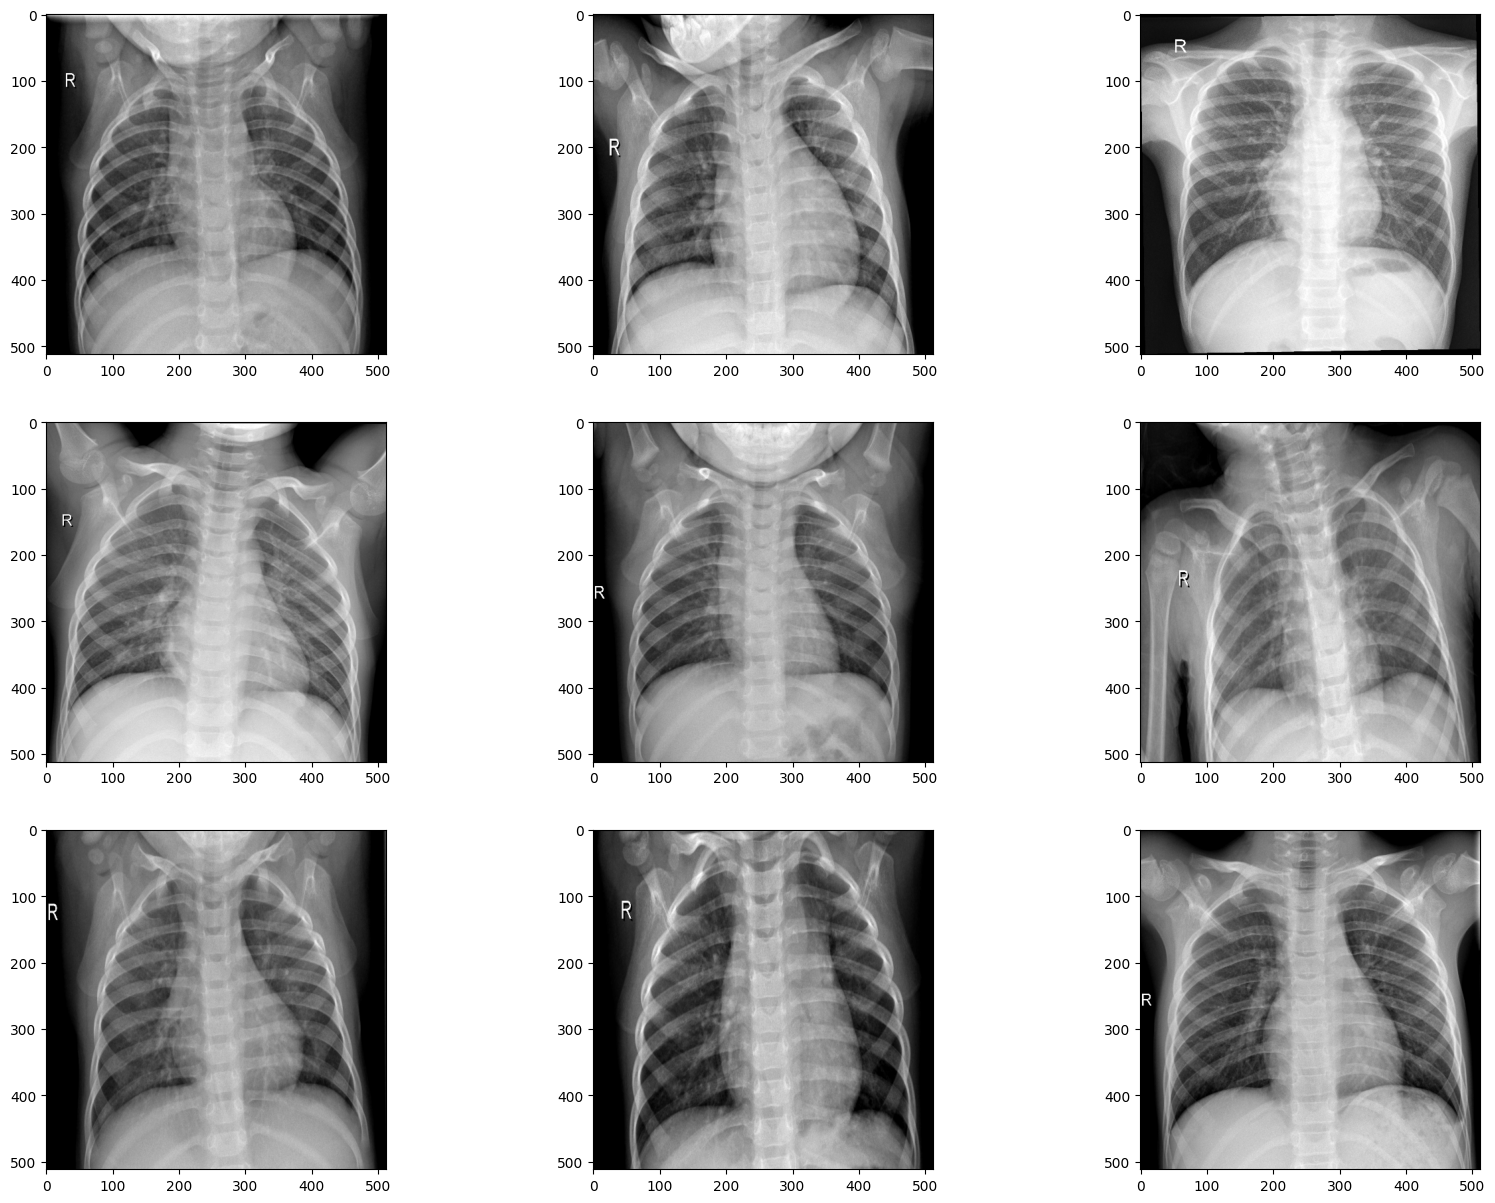

In [17]:
fig = plt.figure(figsize=(20,15))
columns,rows = 3,3
for i in range(1,10):
  img = cv2.imread(images[i])
  img = cv2.resize(img,(512,512))
  fig.add_subplot(rows,columns,i)
  plt.imshow(img)

Image Erosion:
we do this to remove noises and it is a step for edge detection pre processing

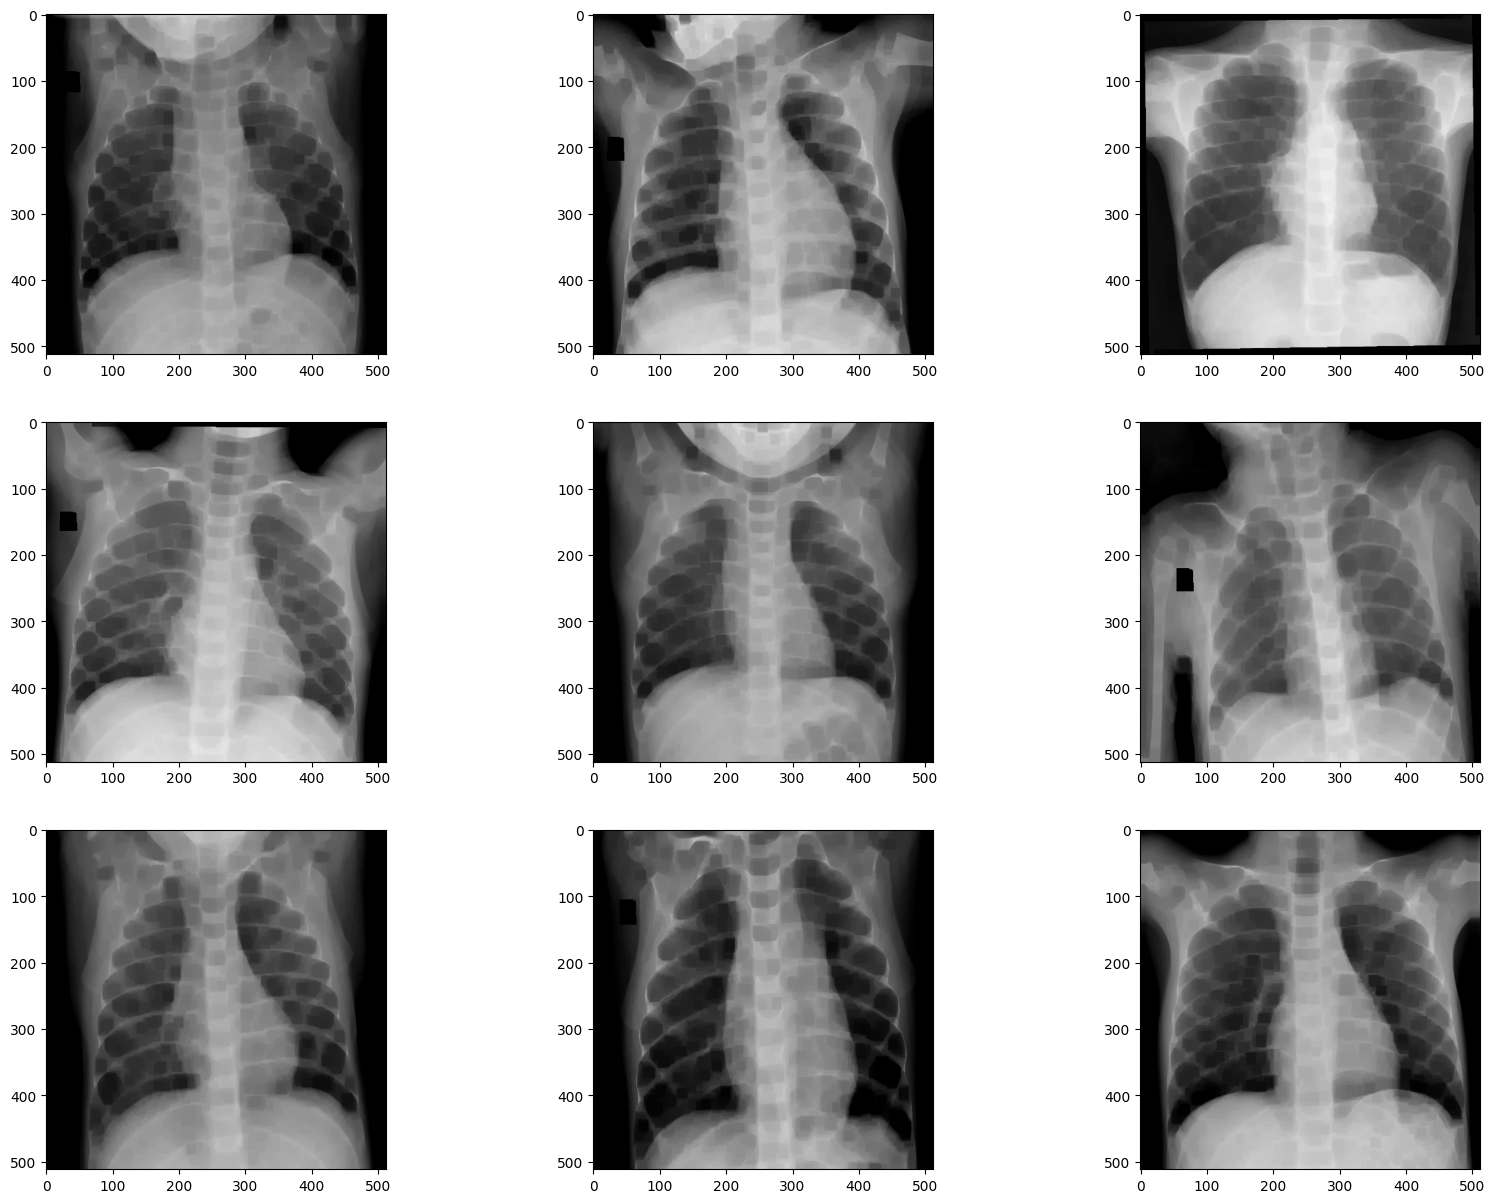

In [18]:
fig = plt.figure(figsize=(20,15))
columns,rows = 3,3
for i in range(1,10):
  img = cv2.imread(images[i])
  img = cv2.resize(img,(512,512))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  kernel = np.ones((5,5),np.uint8)
  image_erosion = cv2.erode(img,kernel,iterations=3)
  fig.add_subplot(rows,columns,i)
  plt.imshow(image_erosion)

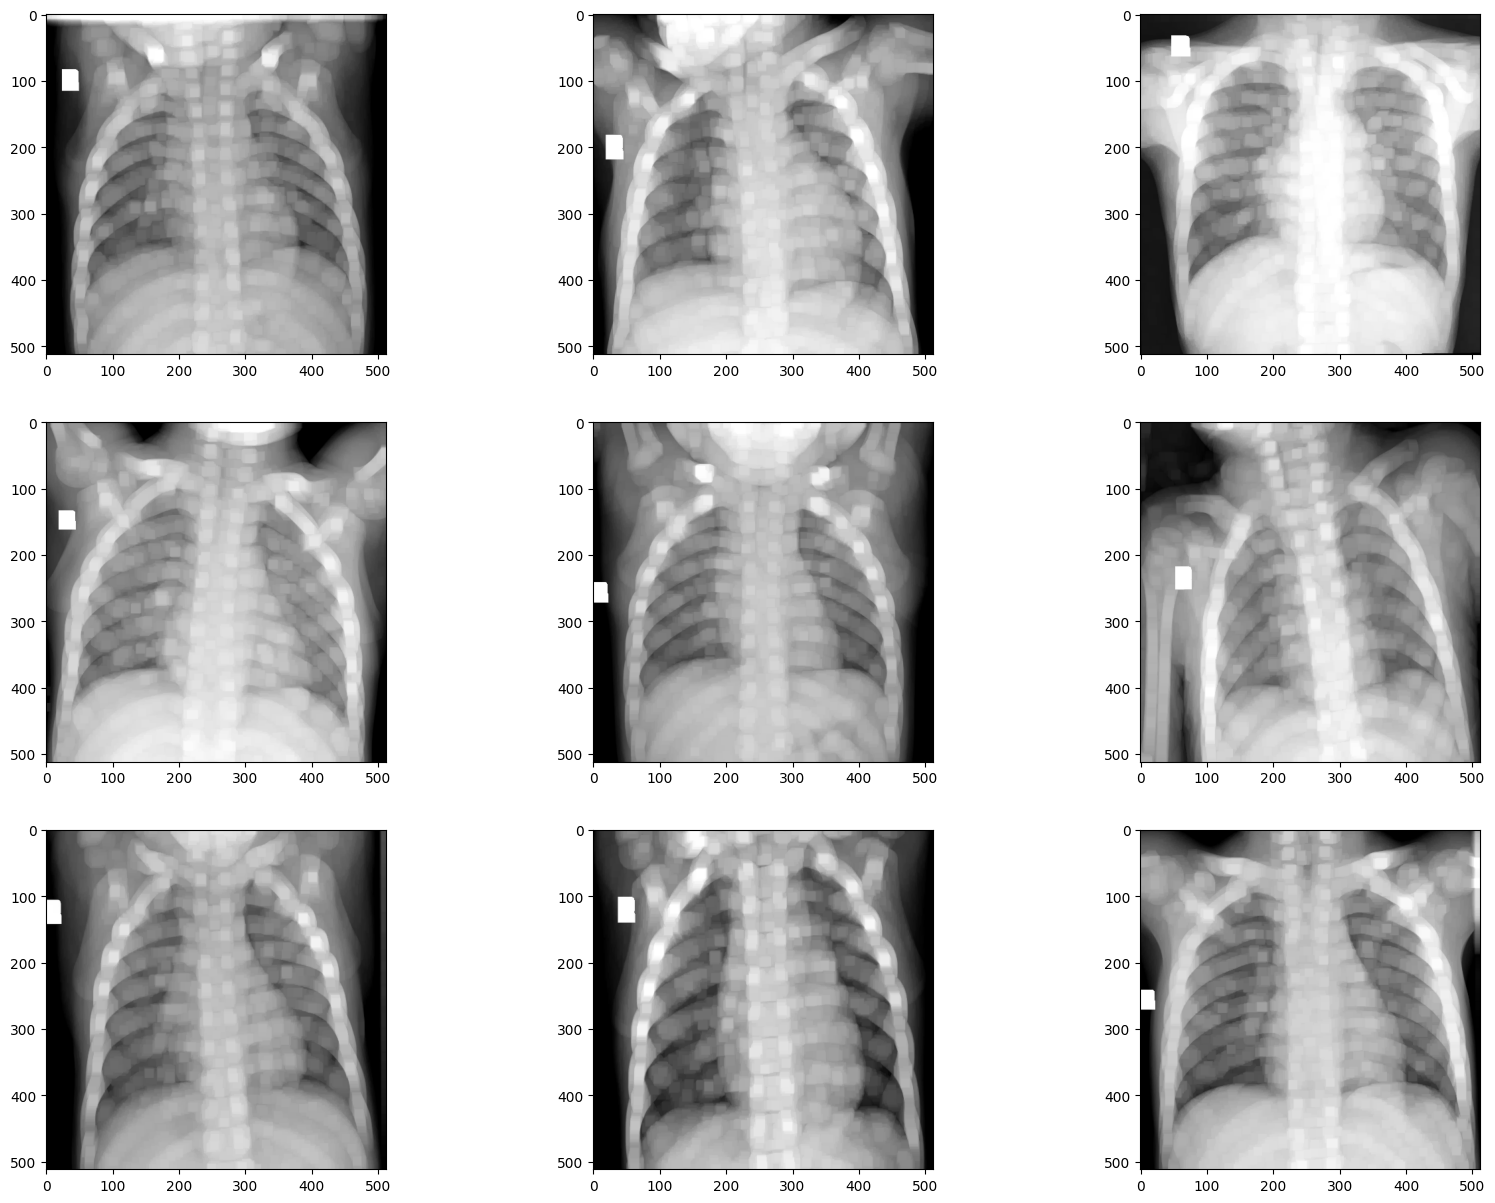

In [19]:
fig = plt.figure(figsize=(20,15))
columns,rows = 3,3
for i in range(1,10):
  img = cv2.imread(images[i])
  img = cv2.resize(img,(512,512))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  kernel = np.ones((5,5),np.uint8)
  image_dilation = cv2.dilate(img,kernel,iterations=3)
  fig.add_subplot(rows,columns,i)
  plt.imshow(image_dilation)

### CANNY EDGE DETECTION

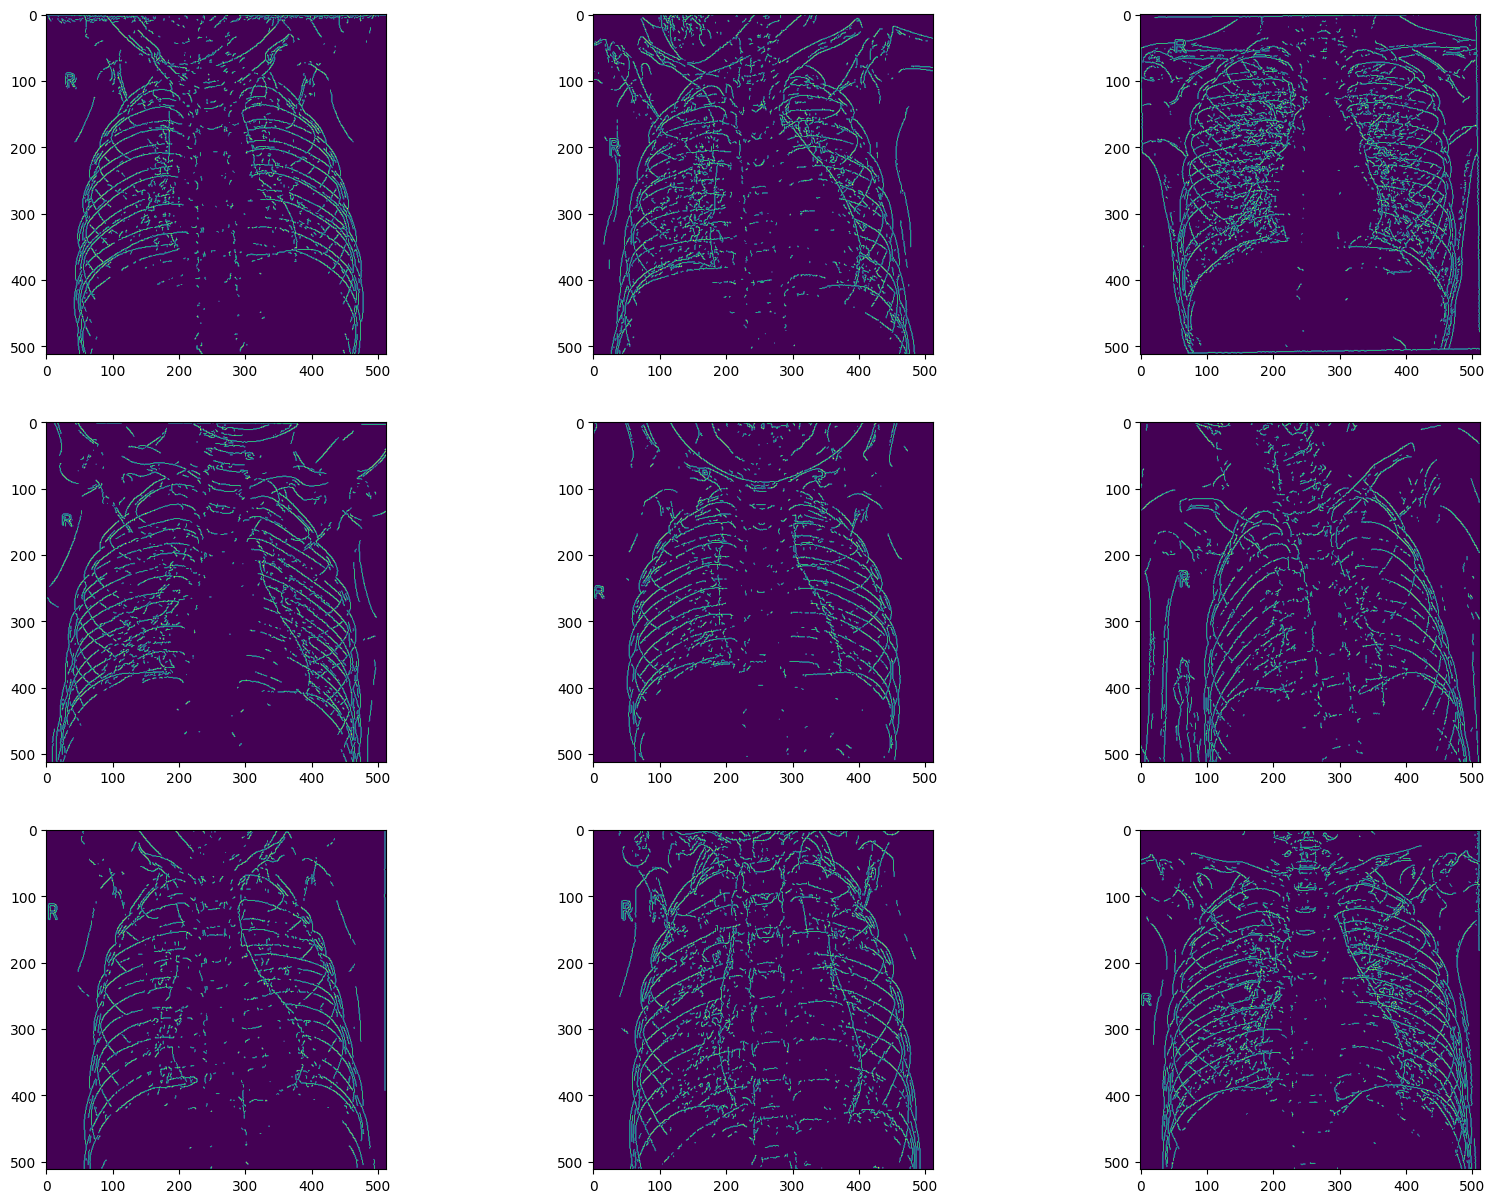

In [20]:
fig = plt.figure(figsize=(20,15))
columns,rows = 3,3
for i in range(1,10):
  img=cv2.imread(images[i])
  img=cv2.resize(img,(512,512))
  img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  detected_edges = cv2.Canny(img,80,100)
  fig.add_subplot(rows,columns,i)
  plt.imshow(detected_edges)

### OTSU THRESHOLDING

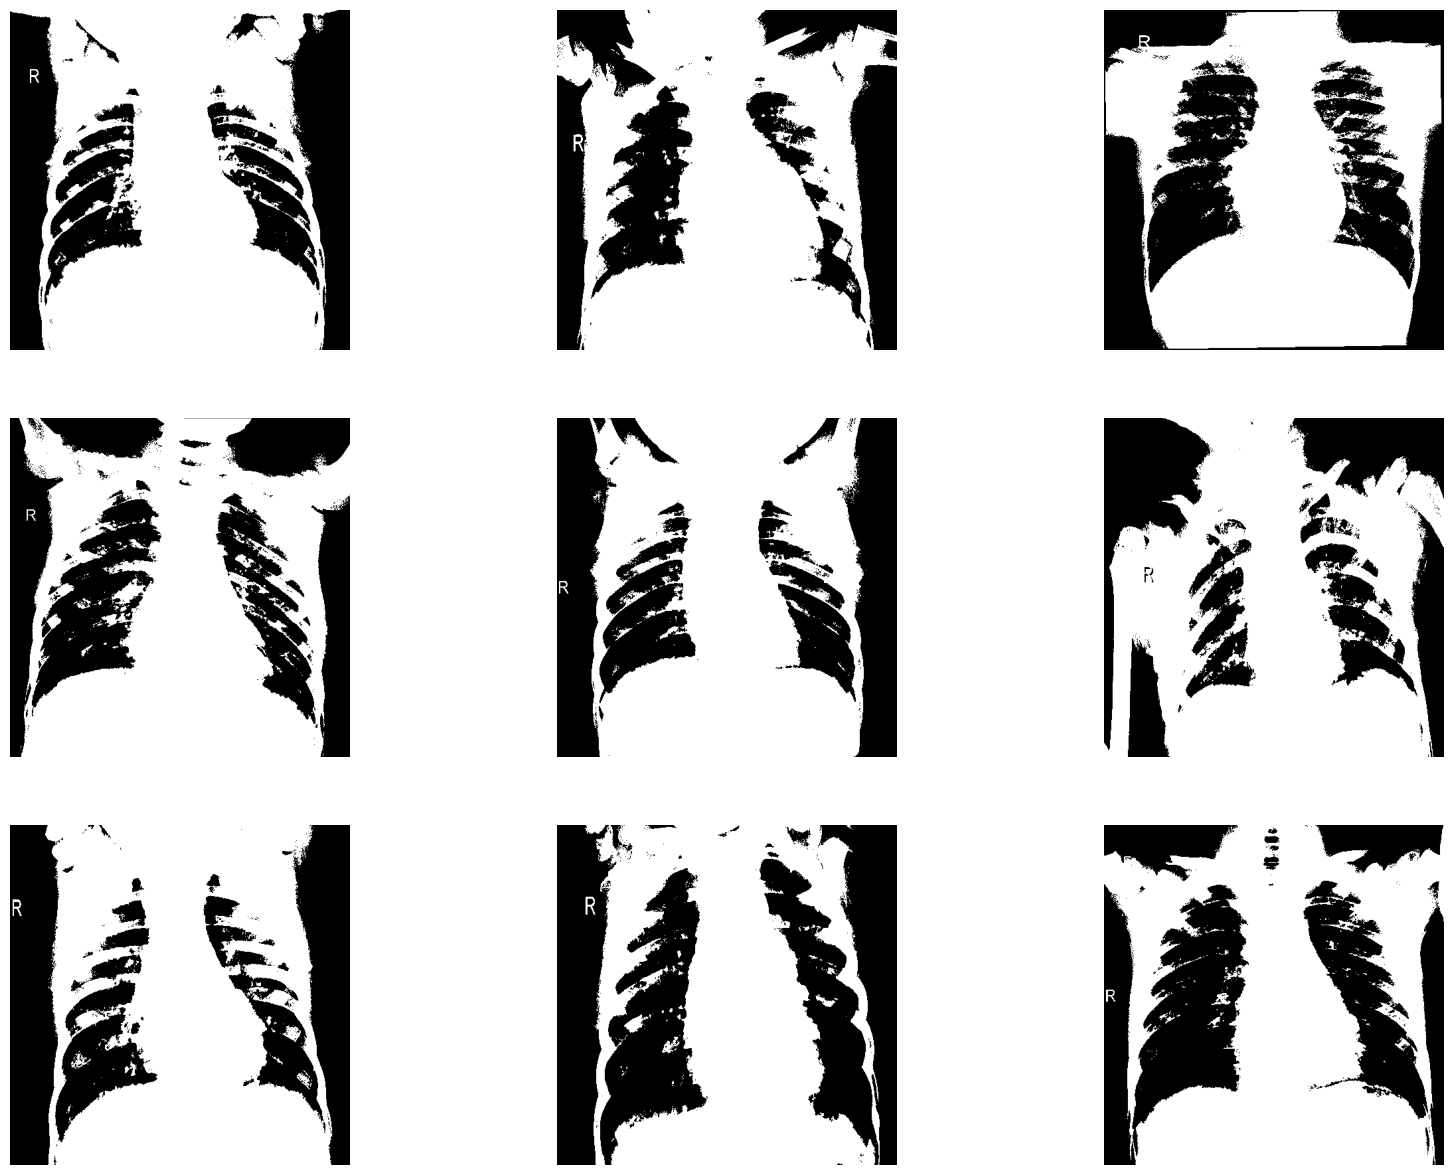

In [21]:

fig = plt.figure(figsize=(20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img=cv2.imread(images[i])
    img=cv2.resize(img,(512,512))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, otsu_thresholded = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    fig.add_subplot(rows, columns, i)
    plt.imshow(otsu_thresholded, cmap='gray')
    plt.axis('off')

plt.show()

## Making the model

In [22]:
train_dir = "/content/chest-xray-pneumonia/chest_xray/train"
test_dir = "/content/chest-xray-pneumonia/chest_xray/test"
validation_dir = "/content/chest-xray-pneumonia/chest_xray/val"

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.3,
    zca_whitening=True,
    width_shift_range=0.25,
    height_shift_range=0.25,
    channel_shift_range=0.35,
    shear_range=0.2,
    zoom_range=-.4)
val_test_datagen=ImageDataGenerator(rescale=1./255)
train_set = train_datagen.flow_from_directory(train_dir,class_mode='binary',batch_size=16,target_size=(224,224))
validation_set = val_test_datagen.flow_from_directory(validation_dir,class_mode='binary',batch_size=16,target_size=(224,224))
test_set = val_test_datagen.flow_from_directory(test_dir,class_mode='binary',batch_size=16,target_size=(224,224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [24]:

# AUTOTUNE = tensorflow.data.experimental.AUTOTUNE

# train_set = train_set.cache().prefetch(buffer_size = AUTOTUNE)
# test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)
# validation_set = validation_set.cache().prefetch(buffer_size = AUTOTUNE)

pass

In [25]:
model1 = Sequential()
model1.add(Conv2D(32,(3,3),strides=(1,1),activation='relu',padding='same',input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(64,(3,3),strides=(1,1),activation='relu',padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128,(3,3),strides=(1,1),activation='relu',padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(256,(3,3),strides=(1,1),activation='relu',padding='same'))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

model1.add(Dense(128,activation='relu'))
model1.add(Dense(64,activation='relu'))
model1.add(Dense(32,activation='relu'))
model1.add(Dense(1,activation='sigmoid'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       7

In [26]:
model1.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [27]:
early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

In [28]:
history = model1.fit(train_set, epochs = 20,
                              validation_data = validation_set,
                              steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])
# history = model1.fit_generator(train_set,epochs=20,validation_data=validation_set,steps_per_epoch=100,callbacks=[early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 36s 346ms/step - loss: 0.5572 - accuracy: 0.7394 - val_loss: 0.7349 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 35s 347ms/step - loss: 0.4122 - accuracy: 0.7806 - val_loss: 0.4971 - val_accuracy: 0.8125
Epoch 3/20
100/100 [==============================] - 35s 347ms/step - loss: 0.4003 - accuracy: 0.8269 - val_loss: 0.4702 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 36s 355ms/step - loss: 0.3841 - accuracy: 0.8175 - val_loss: 0.7757 - val_accuracy: 0.7500
Epoch 5/20
100/100 [==============================] - 34s 336ms/step - loss: 0.3469 - accuracy: 0.8388 - val_loss: 1.0667 - val_accuracy: 0.6250
Epoch 6/20
100/100 [==============================] - 35s 350ms/step - loss: 0.3463 - accuracy: 0.8525 - val_loss: 0.5438 - val_accuracy: 0.7500
Epoch 7/20
100/100 [==============================] - 34s 342ms/step - loss: 0.3282 - accuracy: 0.8600 - val_loss: 0.7056 - val_ac

In [29]:
model1.input, model1.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'conv2d_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>)

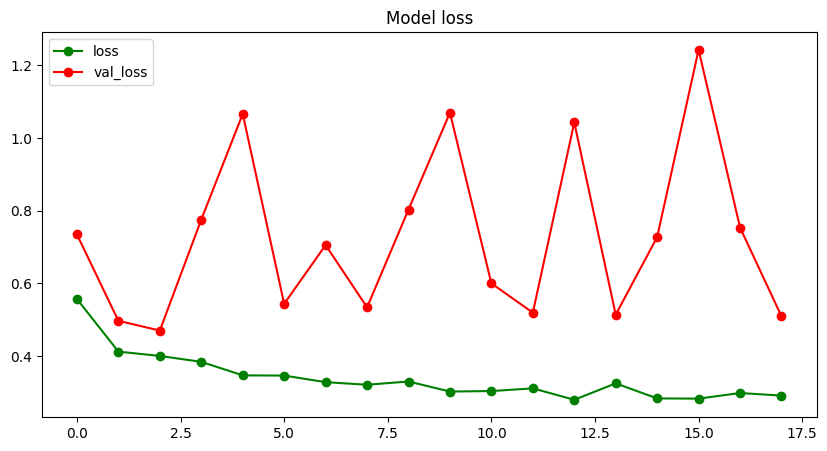

In [30]:
plt.figure(figsize=(10,5))
plt.title('Model loss')
plt.plot(history.history['loss'],"go-")
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss','val_loss'])
plt.show()

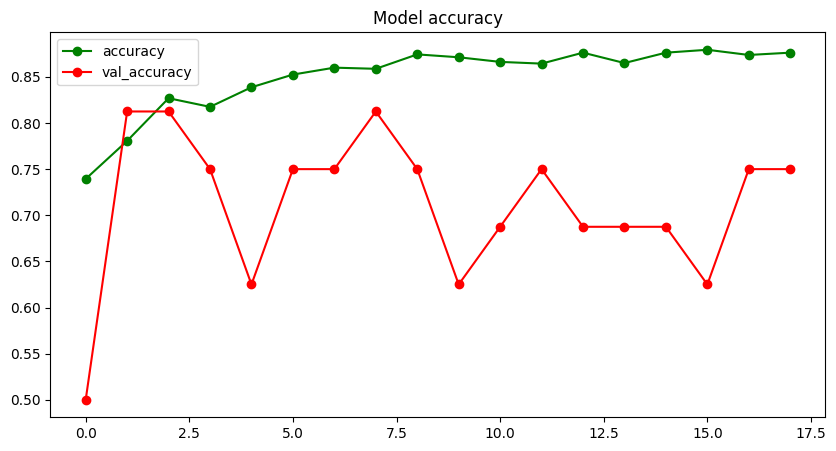

In [31]:
plt.figure(figsize=(10,5))
plt.title('Model accuracy')

plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy','val_accuracy'])
plt.show()

In [32]:
test_loss,test_accuracy = model1.evaluate(test_set,steps=50)
print("The testing accuracy is: ",test_accuracy*100,'%')
print('The testing loss is: ',test_loss*100,'%')

39/50 [======================>.......] - ETA: 1s - loss: 0.4998 - accuracy: 0.7548

50/50 [==============================] - 5s 98ms/step - loss: 0.4998 - accuracy: 0.7548
The testing accuracy is:  75.4807710647583 %
The testing loss is:  49.98309314250946 %


In [33]:
base_model1 = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='max',classes=2)
base_model1.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [34]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())
model2.add(Dense(128,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(32,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

for layer in base_model1.layers:
  layer.trainable = False
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [35]:
history=model2.fit(train_set,epochs=20,validation_data=validation_set,steps_per_epoch=100,callbacks=[early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 43s 421ms/step - loss: 0.4344 - accuracy: 0.7956 - val_loss: 0.3559 - val_accuracy: 0.7500
Epoch 2/20
100/100 [==============================] - 42s 414ms/step - loss: 0.3139 - accuracy: 0.8625 - val_loss: 0.3548 - val_accuracy: 0.8125
Epoch 3/20
100/100 [==============================] - 42s 414ms/step - loss: 0.2831 - accuracy: 0.8775 - val_loss: 0.6333 - val_accuracy: 0.6875
Epoch 4/20
100/100 [==============================] - 42s 416ms/step - loss: 0.2857 - accuracy: 0.8706 - val_loss: 0.7586 - val_accuracy: 0.6875
Epoch 5/20
100/100 [==============================] - 42s 413ms/step - loss: 0.2592 - accuracy: 0.8881 - val_loss: 0.3409 - val_accuracy: 0.8125
Epoch 6/20
100/100 [==============================] - 41s 409ms/step - loss: 0.2520 - accuracy: 0.8900 - val_loss: 0.5641 - val_accuracy: 0.7500
Epoch 7/20
100/100 [==============================] - 42s 414ms/step - loss: 0.2511 - accuracy: 0.8863 - val_loss: 0.4680 - val_ac

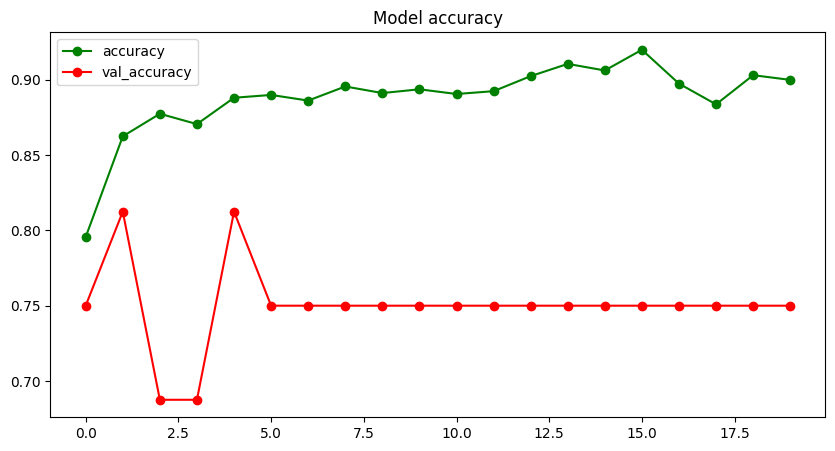

In [36]:
plt.figure(figsize=(10,5))
plt.title("Model accuracy")
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy','val_accuracy'])
plt.show()

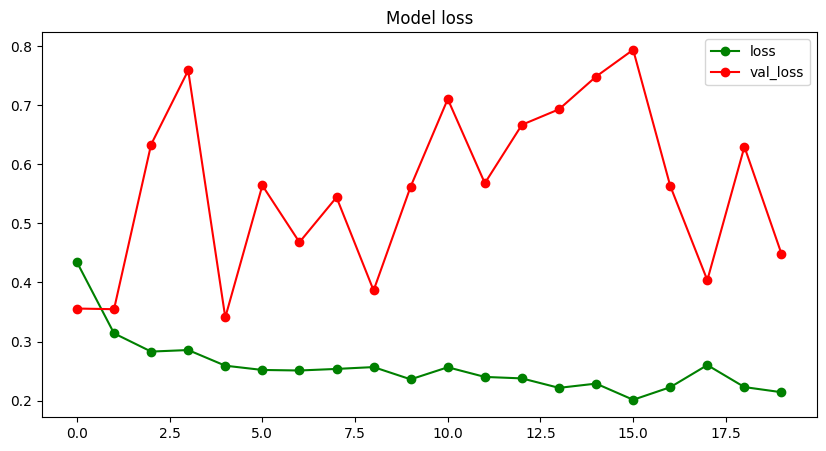

In [37]:
plt.figure(figsize=(10,5))
plt.title("Model loss")
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss','val_loss'])
plt.show()

In [38]:
test_loss, test_accuracy = model2.evaluate(test_set,steps=50)
print("The testing accuracy is ",test_accuracy*100,'%')
print("The testing loss is ",test_loss*100,'%')

39/50 [======================>.......] - ETA: 3s - loss: 0.4757 - accuracy: 0.7516

50/50 [==============================] - 12s 228ms/step - loss: 0.4757 - accuracy: 0.7516
The testing accuracy is  75.16025900840759 %
The testing loss is  47.567278146743774 %


In [39]:
base_model2 = tensorflow.keras.applications.ResNet50V2(weights='imagenet',input_shape=(224,224,3),pooling='max',include_top=False,classes=2)
for layer in base_model2.layers:
  layer.trainable=False

94668760/94668760 [==============================] - 0s 0us/step


In [40]:
model3 = Sequential()
model3.add(base_model2)
model3.add(Flatten())
model3.add(Dense(128,activation='relu'))
model3.add(Dense(64,activation='relu'))
model3.add(Dense(32,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))
for layer in base_model2.layers:
  layer.trainable=False
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [41]:
history = model3.fit(train_set,epochs=20,validation_data=validation_set,steps_per_epoch=100,callbacks=[early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 41s 376ms/step - loss: 0.4488 - accuracy: 0.8238 - val_loss: 0.3544 - val_accuracy: 0.8750
Epoch 2/20
100/100 [==============================] - 36s 361ms/step - loss: 0.2449 - accuracy: 0.9075 - val_loss: 0.3965 - val_accuracy: 0.8750
Epoch 3/20
100/100 [==============================] - 36s 362ms/step - loss: 0.2161 - accuracy: 0.9100 - val_loss: 0.2049 - val_accuracy: 0.8125
Epoch 4/20
100/100 [==============================] - 36s 363ms/step - loss: 0.2265 - accuracy: 0.9075 - val_loss: 0.2129 - val_accuracy: 0.9375
Epoch 5/20
100/100 [==============================] - 37s 367ms/step - loss: 0.2288 - accuracy: 0.9056 - val_loss: 0.2815 - val_accuracy: 0.8750
Epoch 6/20
100/100 [==============================] - 36s 363ms/step - loss: 0.2041 - accuracy: 0.9194 - val_loss: 0.5653 - val_accuracy: 0.8125
Epoch 7/20
100/100 [==============================] - 36s 364ms/step - loss: 0.2178 - accuracy: 0.9081 - val_loss: 0.3209 - val_ac

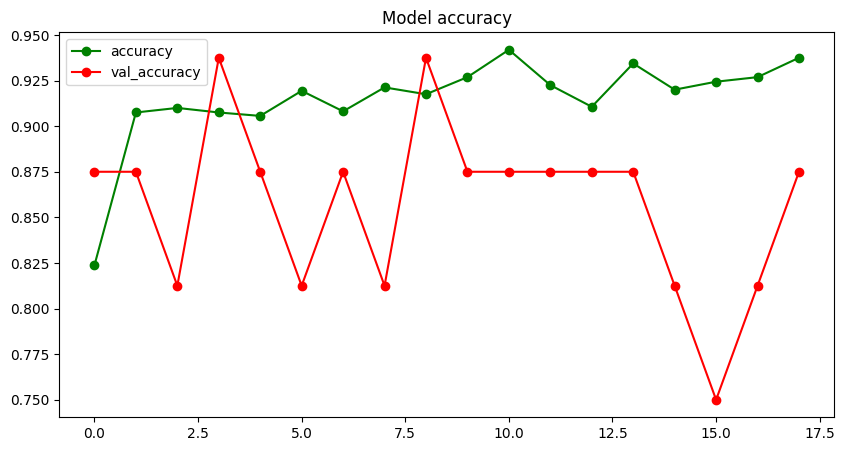

In [42]:
plt.figure(figsize=(10,5))
plt.title('Model accuracy')
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy','val_accuracy'])

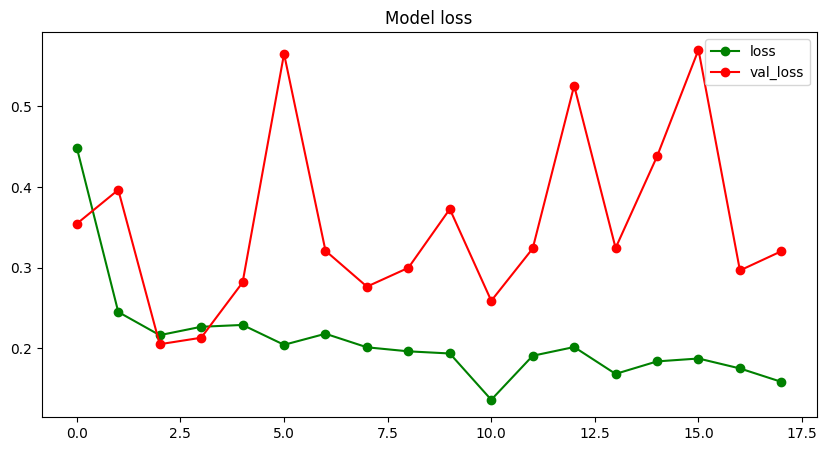

In [43]:
plt.figure(figsize=(10,5))
plt.title('Model loss')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss','val_loss'])

In [44]:
test_loss,test_accuracy = model3.evaluate(test_set,steps=50)
print("The testing accuracy is: ",test_accuracy*100,'%')
print("The testing loss is: ",test_loss*100,'%')

39/50 [======================>.......] - ETA: 2s - loss: 0.3969 - accuracy: 0.8494

50/50 [==============================] - 8s 159ms/step - loss: 0.3969 - accuracy: 0.8494
The testing accuracy is:  84.93589758872986 %
The testing loss is:  39.694803953170776 %


In [44]:
new_image_path = '/content/test_image.jpg'
test_image = image.load_img(new_image_path,target_size=(224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
test_image = test_image/255

result = model3.predict(test_image)
train_set.class_indices

if result[0][0]==0:
  print(" N O R M A L")
else:
  print(' P N E U M O N I A')

In [45]:
model3.save('pneumonia_detector_model.h5')
print("Model was successfully saved to disk___")

Model was successfully saved to disk___


In [46]:
model_loaded = tensorflow.keras.models.load_model('/content/pneumonia_detector_model.h5')
model_loaded.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 23837441 (90.93 MB)
Trainable params: 27

1/1 [==============================] - 1s 917ms/step
The image shows 100.00 percent P N E U M O N I A


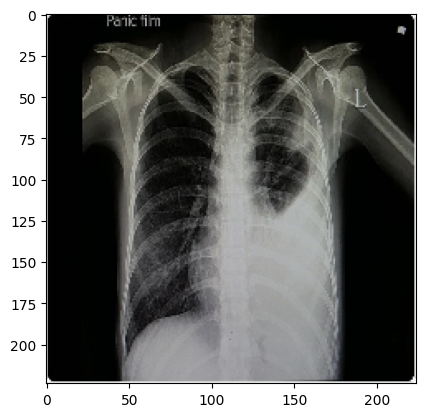

In [49]:
def image_prediction(new_image_path):
  test_image = image.load_img(new_image_path,target_size=(224,224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image,axis=0)
  test_image = test_image/255.0
  model_loaded = tensorflow.keras.models.load_model('/content/pneumonia_detector_model.h5')
  prediction = model_loaded.predict(test_image)
  test_image_for_plotting = image.load_img(new_image_path,target_size=(224,224))
  plt.imshow(test_image_for_plotting)
  if prediction[0]>0.5:
    stats = prediction[0]*100
    print("The image shows %.2f percent %s"% (stats,'P N E U M O N I A'))
  else:
    stats = (1.0 - prediction[0])*100
    print("The image shows %.2f percent %s"% (stats,'N O R M A L'))
image_prediction('/content/image.webp')

In [50]:
test_dir = '/content/chest-xray-pneumonia/chest_xray/test'
test_data,test_labels = [],[]

In [51]:
for i in ["/NORMAL/",'/PNEUMONIA/']:
  for image in (os.listdir(test_dir+i)):
    image = plt.imread(test_dir + i + image)
    image = cv2.resize(image,(224,224))
    image = np.dstack([image,image,image])
    image = image.astype('float32')/255
    if i =='/NORMAL/':
      label = 0
    elif i=='/PNEUMONIA/':
      label = 1
    test_data.append(image)
    test_labels.append(label)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

___C o n f u s i o n  M a t r i x___

20/20 [==============================] - 8s 382ms/step


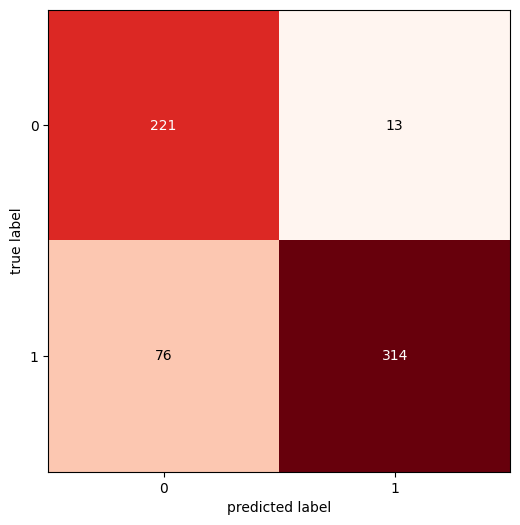

In [53]:
print("___C o n f u s i o n  M a t r i x___\n")
predictions = model_loaded.predict(test_data)
conf_mat = confusion_matrix(test_labels,np.round(predictions))
accuracy = accuracy_score(test_labels,np.round(predictions))*100
tn,fp,fn,tp = conf_mat.ravel()
fig,ax = plot_confusion_matrix(conf_mat=conf_mat,figsize = (6,6),cmap=plt.cm.Reds)
plt.show()

In [54]:
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print("Accuracy: {}%".format(accuracy))
print("Precision: {}%".format(precision))
print("Recall: {}%".format(recall))
print("F1-score: {}%".format(2*precision*recall/(precision+recall)))

Accuracy: 85.73717948717949%
Precision: 96.02446483180428%
Recall: 80.51282051282051%
F1-score: 87.58716875871687%


In [55]:
predictions = list()
preds = model_loaded.predict(test_data)
for i in preds:
  if i>=0.5:
    predictions.append(1)
  else:
    predictions.append(0)
predictions[:15]

20/20 [==============================] - 8s 386ms/step


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [56]:
correct_predictions = np.nonzero(predictions==test_labels)[0]
incorrect_predictions = np.nonzero(predictions != test_labels)[0]

print('Indices of correct predictions:\n',correct_predictions[:15])
print('Indices of incorrect predictions:\n',incorrect_predictions[:15])

Indices of correct predictions:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Indices of incorrect predictions:
 [ 35  54  61  77 112 177 178 195 198 202 210 213 219 238 240]


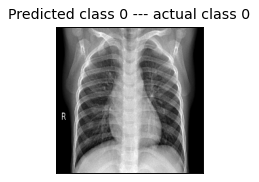

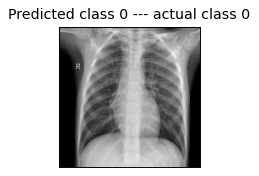

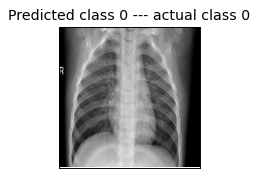

In [60]:
# i=0
# for a in correct_predictions[:3]:
#   plt.figure(figsize=(8,6),dpi=85)
#   plt.subplot(3,1,i+1)
#   plt.xticks([]),plt.yticks([])
#   plt.imshow(test_data[a].reshape(224,224,3))
#   plt.title("Predicted class {} --- actual class {}".format(predictions[a],test_labels[a]))
#   plt.tight_layout()
#   i+=1
i = 0
for a in correct_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1

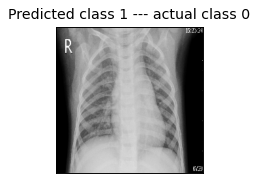

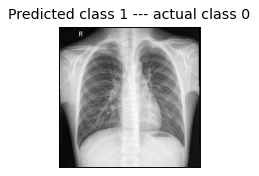

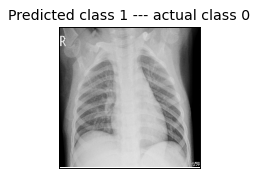

In [58]:
i = 0
for a in incorrect_predictions[:3]:
    plt.figure(figsize = (8, 6), dpi = 85)
    plt.subplot(3, 1, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_data[a].reshape(224, 224, 3))
    plt.title("Predicted class {} --- actual class {}".format(predictions[a], test_labels[a]))
    plt.tight_layout()
    i += 1